In [1]:
################################
# Scientific imports
################################
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astroquery.mast import Observations
from astroquery.mast import Catalogs

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange

################################
# SciKitLearn Imports
################################
import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from IPython.display import display

################################
# MatPlotLib Settings
################################
plt.rcParams["figure.figsize"] = (20,9)
sb.set()

################################
# Initialisers
################################

# Load the Data files
fitsarr = np.load("fitslist.npy")
fluxarr = np.load("fluxlist.npy")
#planetarr = np.load("planetlist.npy")
isplanetarr = np.load("isplanetlist.npy")

In [2]:
def DrawLC(rndFile=-1):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']
        obj       = hdulist[0].header['OBJECT']
        sector    = hdulist[0].header['SECTOR']


        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds     = hdulist[1].data['TIME']
        sap_fluxes    = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # X- and Y- labels
    ylab = "PDCSAP Flux (e-/s)"
    xlab = "Time (TBJD)"

    #ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)
    return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector), ylab, xlab)

Text(0, 0.5, 'PDCSAP Flux (e-/s)')

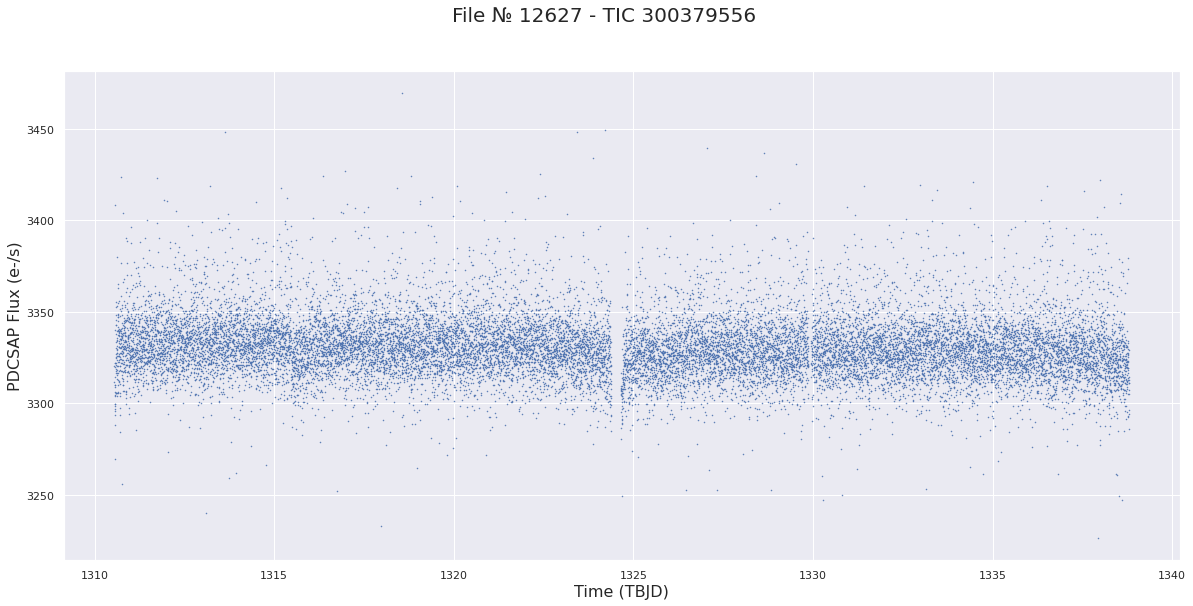

In [5]:
x,y,f,o,s,ylab,xlab = DrawLC(10279)
x,y,f,o,s,ylab,xlab = DrawLC(12627)

fig, ax = plt.subplots()
ax.plot(x,y, '.', markersize=1)
fig.suptitle("File № {} - {}".format(f, o), fontsize=20) # + str(obj) + " - Sector " + str(sector))
ax.set_xlabel(xlab, fontsize=16)
ax.set_ylabel(ylab, fontsize=16)

/home/jdowzell/anaconda3/lib/python3.8/site-packages/astropy/timeseries/io/kepler.py:82: UserWarning: Ignoring 259 rows with NaN times
  warnings.warn(f'Ignoring {np.sum(nans)} rows with NaN times')


Text(0, 0.5, 'SAP Flux (e-/s)')

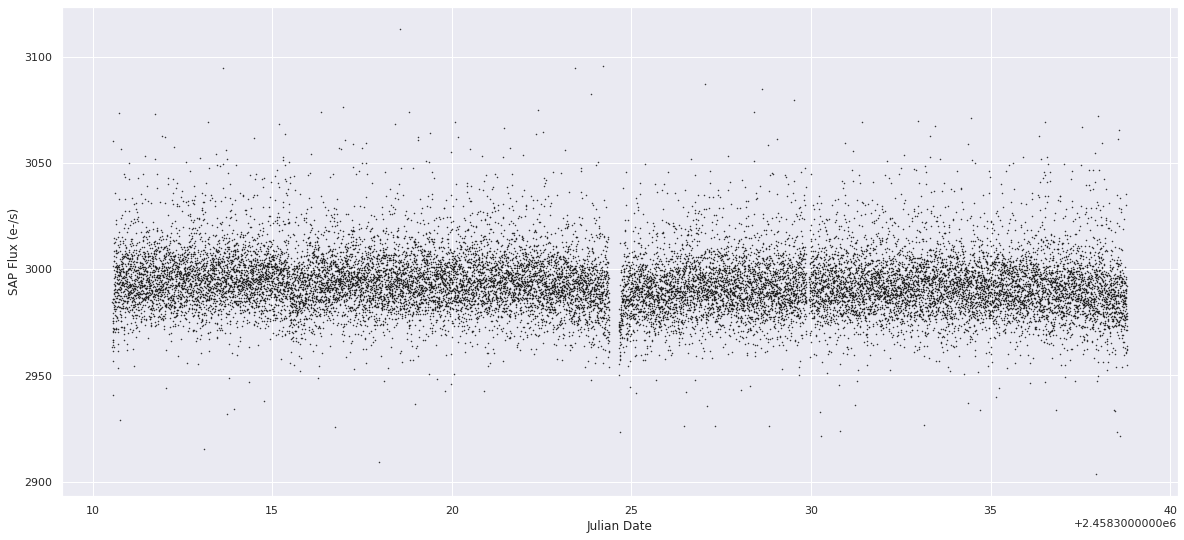

In [39]:
ts = TimeSeries.read(fitsarr[int(f)], format='tess.fits')  
periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')
plt.plot(ts.time.jd, ts['sap_flux'], 'k.', markersize=1)
plt.xlabel('Julian Date')
plt.ylabel('SAP Flux (e-/s)')

Text(0, 0.5, 'SAP Flux (e-/s)')

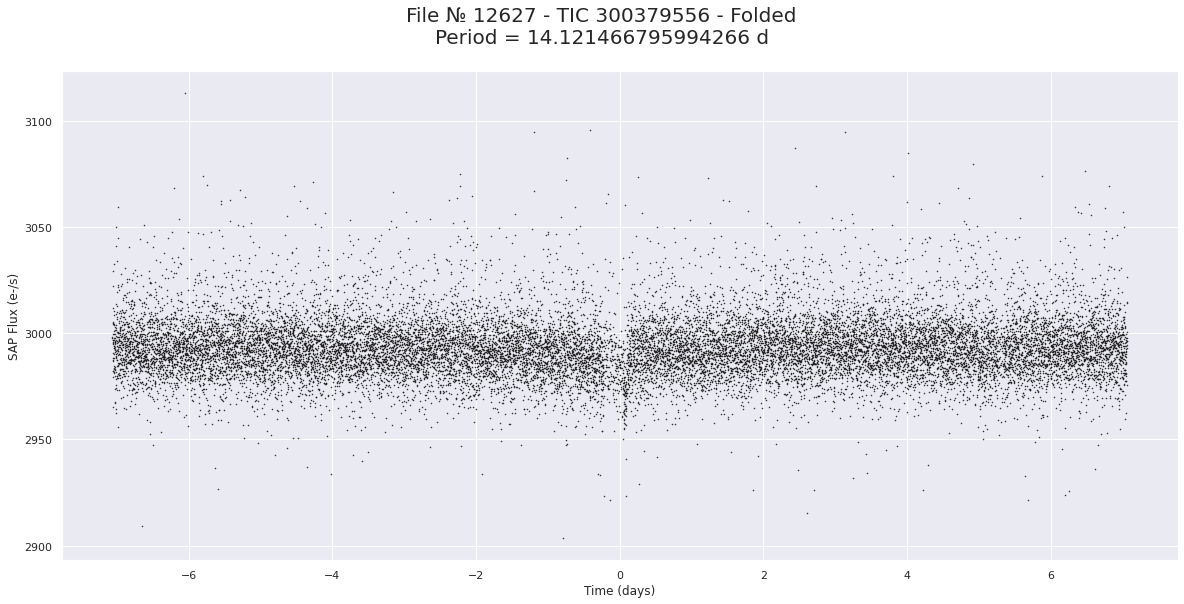

In [40]:
results = periodogram.autopower(0.2 * u.day)  
best = np.argmax(results.power)  
period = results.period[best]

transit_time = results.transit_time[best]  
ts_folded = ts.fold(period=period, epoch_time=transit_time)

#fig, ax = plt.subplots()
plt.suptitle("File № {} - {} - Folded\nPeriod = {}".format(f, o, period), fontsize=20)
plt.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
plt.xlabel('Time (days)')
plt.ylabel('SAP Flux (e-/s)')

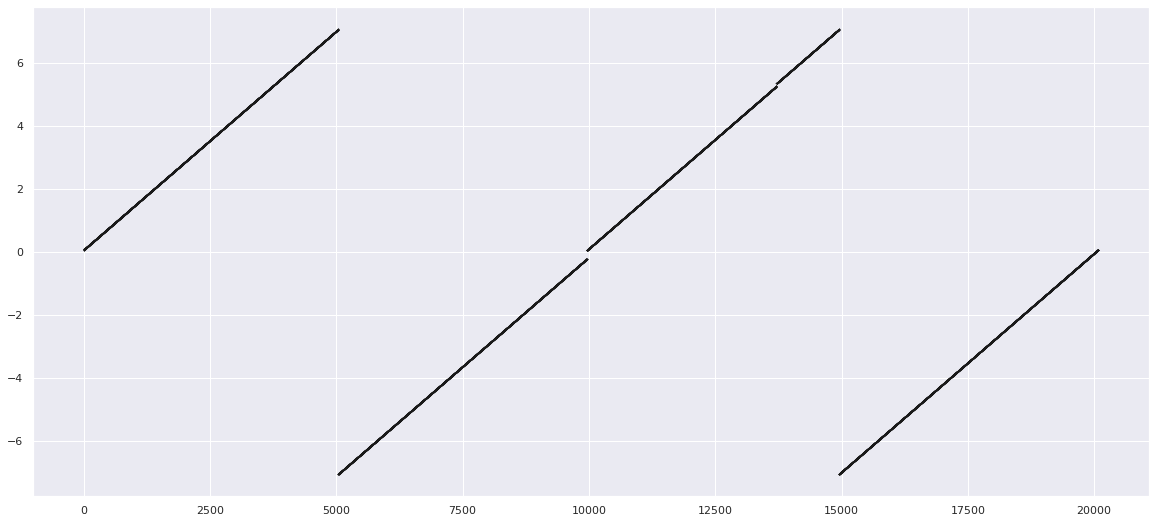

In [8]:
plt.plot(ts_folded.time.jd, 'k.', markersize=1)

### Now to test on a LC that appears to be garbage (ie, should have no periodic features)

Text(0, 0.5, 'PDCSAP Flux (e-/s)')

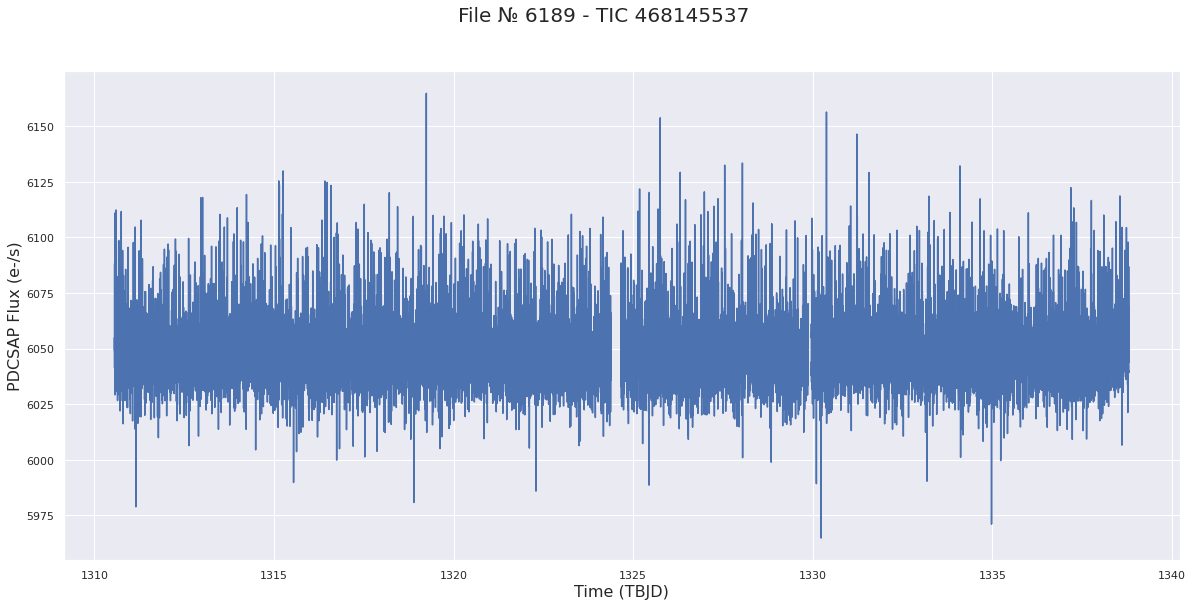

In [9]:
x2,y2,f2,o2,s2,ylab2,xlab2 = DrawLC(6189)

fig, ax = plt.subplots()
ax.plot(x2,y2)
fig.suptitle("File № {} - {}".format(f2, o2), fontsize=20) # + str(obj) + " - Sector " + str(sector))
ax.set_xlabel(xlab2, fontsize=16)
ax.set_ylabel(ylab2, fontsize=16)

/home/jdowzell/anaconda3/lib/python3.8/site-packages/astropy/timeseries/io/kepler.py:82: UserWarning: Ignoring 259 rows with NaN times
  warnings.warn(f'Ignoring {np.sum(nans)} rows with NaN times')


Text(0, 0.5, 'SAP Flux (e-/s)')

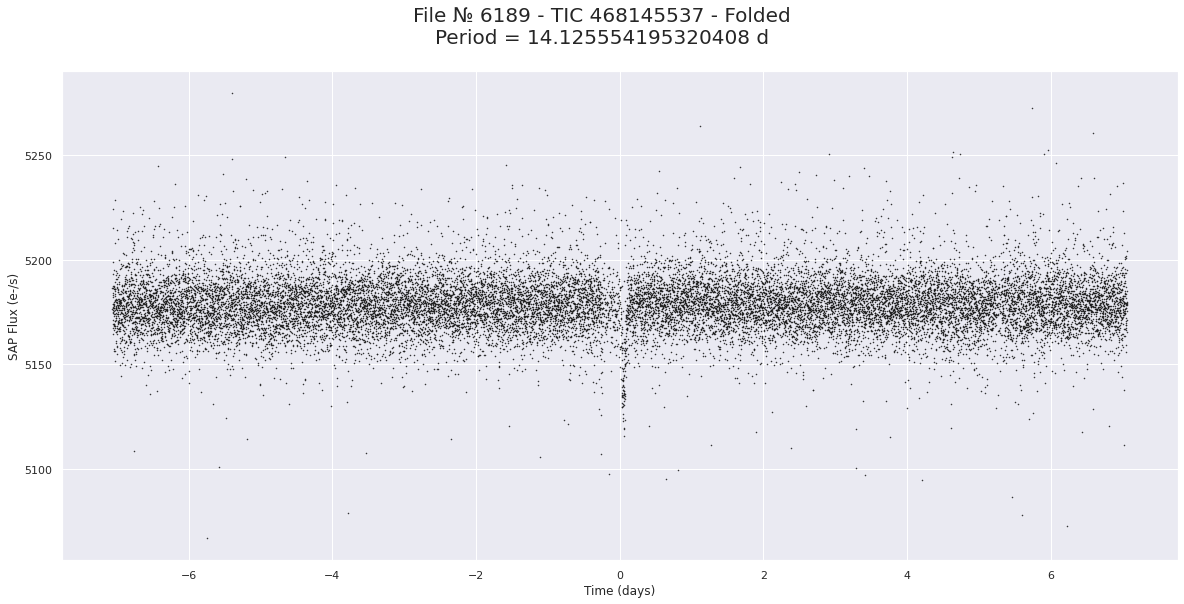

In [10]:
ts2 = TimeSeries.read(fitsarr[int(f2)], format='tess.fits')  
periodogram2 = BoxLeastSquares.from_timeseries(ts2, 'sap_flux')
#plt.plot(ts.time.jd, ts['sap_flux'], 'k.', markersize=1)
#plt.xlabel('Julian Date')
#plt.ylabel('SAP Flux (e-/s)')

results2 = periodogram2.autopower(0.2 * u.day)  
best2 = np.argmax(results2.power)  
period2 = results2.period[best2]

transit_time2 = results2.transit_time[best2]  
ts_folded2 = ts2.fold(period=period2, epoch_time=transit_time2)

#fig, ax = plt.subplots()
plt.suptitle("File № {} - {} - Folded\nPeriod = {}".format(f2, o2, period2), fontsize=20)
plt.plot(ts_folded2.time.jd, ts_folded2['sap_flux'], 'k.', markersize=1)
plt.xlabel('Time (days)')
plt.ylabel('SAP Flux (e-/s)')

So it seems like a garbage plot yields equally garbage results, this is good to see, as this means using this technique is likely a clear indication of whether a plot has periodicity or not.

Now let's try on a timeseries that seems to be neither a LC nor just noise: 8446

/home/jdowzell/anaconda3/lib/python3.8/site-packages/astropy/timeseries/io/kepler.py:82: UserWarning: Ignoring 259 rows with NaN times
  warnings.warn(f'Ignoring {np.sum(nans)} rows with NaN times')


Text(0, 0.5, 'SAP Flux (e-/s)')

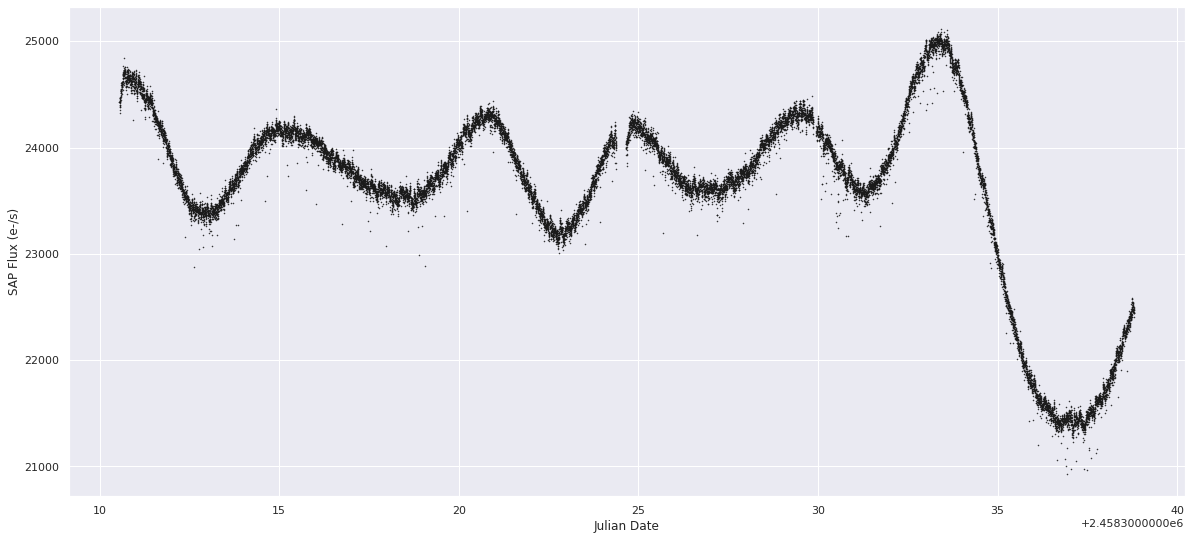

In [11]:
ts = TimeSeries.read(fitsarr[8446], format='tess.fits')  
periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')
plt.plot(ts.time.jd, ts['sap_flux'], 'k.', markersize=1)
plt.xlabel('Julian Date')
plt.ylabel('SAP Flux (e-/s)')

Text(0, 0.5, 'SAP Flux (e-/s)')

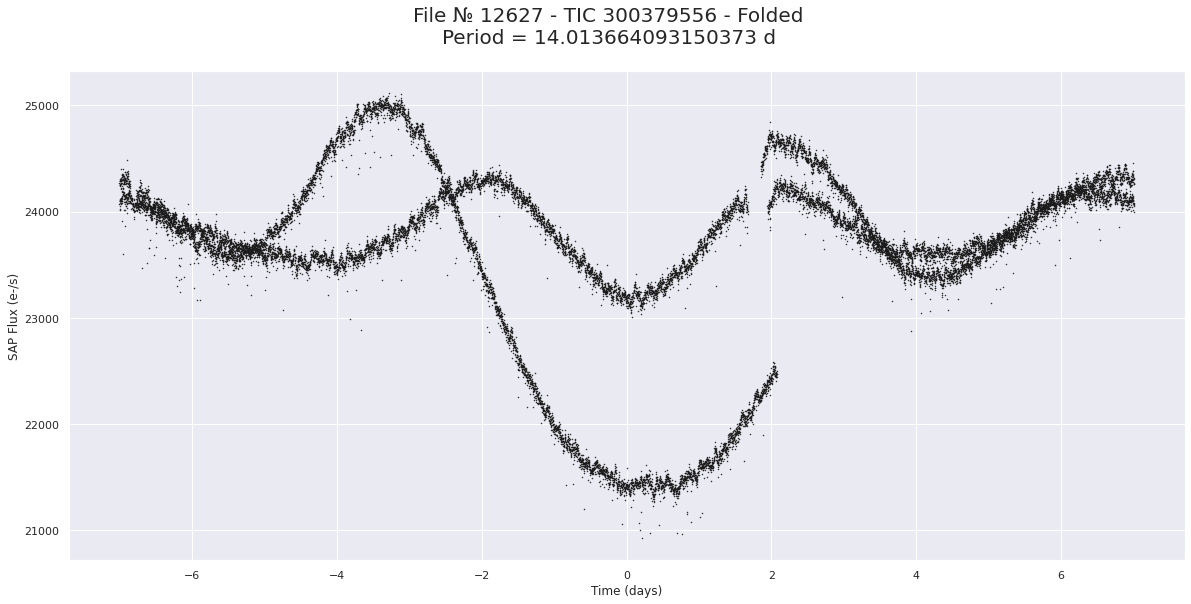

In [12]:
results = periodogram.autopower(0.2 * u.day)  
best = np.argmax(results.power)  
period = results.period[best]

transit_time = results.transit_time[best]  
ts_folded = ts.fold(period=period, epoch_time=transit_time)

#fig, ax = plt.subplots()
plt.suptitle("File № {} - {} - Folded\nPeriod = {}".format(f, o, period), fontsize=20)
plt.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
plt.xlabel('Time (days)')
plt.ylabel('SAP Flux (e-/s)')

A period of ~14 days is roughly half of the timeseries; each LC is designed to be the following length:

In [13]:
print("{} days".format(x[-1]-x[0]))

28.245458167896686 days


Half of which is approx 14 days, so this implies* that anything with a period of around 14 days is unlikely to be a valid light curve  
(* at least in this sample dataset)

In [14]:
results

          depth: <Quantity [   5.10147685,    4.99973593,    4.41220574, ..., 1358.19936099,
           1352.98212728, 1348.71167949] electron / s>
      depth_err: <Quantity [0.01411361, 0.01411361, 0.01411367, ..., 0.05935272, 0.05935272,
           0.05935272] electron / s>
      depth_snr: <Quantity [  361.45801186,   354.24916397,   312.61924727, ...,
           22883.52423754, 22795.62205071, 22723.67171832]>
       duration: <Quantity [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2] d>
 log_likelihood: <Quantity [1.30411606e+05, 1.25236770e+05, 9.73864663e+04, ...,
           2.65637593e+08, 2.63600732e+08, 2.61939340e+08] electron2 / s2>
      objective: 'likelihood'
         period: <Quantity [ 0.4       ,  0.40004011,  0.40008022, ..., 14.01366409,
           14.06305773, 14.1128008 ] d>
          power: <Quantity [1.30411606e+05, 1.25236770e+05, 9.73864663e+04, ...,
           2.65637593e+08, 2.63600732e+08, 2.61939340e+08] electron2 / s2>
   transit_time: <Time object: scale='tdb' forma

In [15]:
results.period

<Quantity [ 0.4       ,  0.40004011,  0.40008022, ..., 14.01366409,
           14.06305773, 14.1128008 ] d>

In [16]:
len(results.period)

9693

In [17]:
len(results.power)

9693

In [18]:
max(results.power)

<Quantity 2.65637593e+08 electron2 / s2>

In [19]:
results.power

<Quantity [1.30411606e+05, 1.25236770e+05, 9.73864663e+04, ...,
           2.65637593e+08, 2.63600732e+08, 2.61939340e+08] electron2 / s2>

In [20]:
maxind = np.argmax(results.power)
maxind

9690

In [21]:
results.power[maxind]

<Quantity 2.65637593e+08 electron2 / s2>

In [22]:
results.period[maxind]

<Quantity 14.01366409 d>